In [618]:
from matplotlib import pyplot as plt
from math import sqrt, log, exp
import numpy as np
from statistics import NormalDist

In [619]:
class BlackScholesCalc:
    def get_d1_d2(s0, k, t, iv, r):
        d1 = (log(s0 / k) + (r + 0.5 * iv ** 2) * t) / (iv * sqrt(t))
        d2 = d1 - (iv * sqrt(t))
        return d1, d2
    def intrinsic_value(op_type, s0, k):
        if op_type.lower() == "call":
            return max(0, s0 - k)
        elif op_type.lower() == "put":
            return max(0, k - s0)
    def call_price(s0, k, t, iv, r):
        if t == 0: return BlackScholesCalc.intrinsic_value("call", s0, k)
        d1, d2 = BlackScholesCalc.get_d1_d2(s0, k, t, iv, r)
        return (s0 * NormalDist().cdf(d1)) - (k * exp(-r * t) * NormalDist().cdf(d2))
    def put_price(s0, k, t, iv, r):
        if t == 0: return BlackScholesCalc.intrinsic_value("put", s0, k)
        d1, d2 = BlackScholesCalc.get_d1_d2(s0, k, t, iv, r)
        return (k * exp(-r * t) * NormalDist().cdf(-d2)) - (s0 * NormalDist().cdf(-d1))
    def option_price(op_type, s0, k, t, iv, r):
        if op_type.lower() == "call":
            return BlackScholesCalc.call_price(s0, k, t, iv, r)
        elif op_type.lower() == "put":
            return BlackScholesCalc.put_price(s0, k, t, iv, r)
    def option_delta(op_type, s0, k, t, iv, r):
        h = 0.01
        current = BlackScholesCalc.option_price(op_type, s0, k, t, iv, r)
        bumped = BlackScholesCalc.option_price(op_type, s0 + h, k, t, iv, r)
        return (bumped - current) / h
    def option_gamma(op_type, s0, k, t, iv, r):
        h = 0.01
        current = BlackScholesCalc.option_delta(op_type, s0, k, t, iv, r)
        bumped = BlackScholesCalc.option_delta(op_type, s0 + h, k, t, iv, r)
        return (bumped - current) / h
    def charm_call(s0, k, t, iv, r):    
        d1, d2 = BlackScholesCalc.get_d1_d2(s0, k, t, iv, r)
        nd1_pdf = NormalDist().pdf(d1)
        a = -nd1_pdf / (2 * sqrt(t))
        b = (2 * r * t - d2 * iv * sqrt(t)) / (iv * t)
        return a * b
    def charm_put(s0, k, t, iv, r):
        d1, d2 = BlackScholesCalc.get_d1_d2(s0, k, t, iv, r)
        nd1_pdf = NormalDist().pdf(d1)
        nd1_cdf = NormalDist().cdf(-d1)
        a = -nd1_pdf / (2 * sqrt(t))
        b = (2 * r * t - d2 * iv * sqrt(t)) / (iv * t)
        c = -r * exp(-r * t) * nd1_cdf
        return a * b + c
    def option_charm(op_type, s0, k, t, iv, r):
        if op_type.lower() == "call":
            return BlackScholesCalc.charm_call(s0, k, t, iv, r)
        elif op_type.lower() == "put":
            return BlackScholesCalc.charm_put(s0, k, t, iv, r)
    def analytical_option_vanna(s0, k, t, iv, r):
        d1, d2 = BlackScholesCalc.get_d1_d2(s0, k, t, iv, r)
        nd1_pdf = NormalDist().pdf(d1)
        return (nd1_pdf * d2) / iv
class Option:
    def __init__(self, op_type, s0, k, t, iv, r):
        self.stock_price = s0
        self.strike = k
        self.years = t
        self.implied_vol = iv
        self.interest_rate = r
        self.option_type = op_type
    def intrinsic_value(self):
        return BlackScholesCalc.intrinsic_value(self.option_type, self.stock_price, self.strike)
    def price(self):
        return BlackScholesCalc.option_price(self.option_type, self.stock_price, self.strike, self.years, self.implied_vol, self.interest_rate)
    def delta(self):
        return BlackScholesCalc.option_delta(self.option_type, self.stock_price, self.strike, self.years, self.implied_vol, self.interest_rate)
    def gamma(self):
        return BlackScholesCalc.option_gamma(self.option_type, self.stock_price, self.strike, self.years, self.implied_vol, self.interest_rate)
    def charm(self):
        return BlackScholesCalc.option_charm(self.option_type, self.stock_price, self.strike, self.years, self.implied_vol, self.interest_rate)
    def vanna(self):
        return BlackScholesCalc.analytical_option_vanna(self.stock_price, self.strike, self.years, self.implied_vol, self.interest_rate)
    

# Option
- <b>Stock Price:</b> \$100
- <b>Strike:</b> \$100
- <b>Years to Expiration:</b> 1 year
- <b>Implied Volatility:</b> 30%
- <b>Interest Rate:</b> 4.12%

In [620]:
option = Option("Call", 100, 100, 1, 0.3, 0.0412)
s0 = option.stock_price
option.charm()

-0.05499691242936269

In [621]:
lim = int(s0 * (sqrt(option.years)+1.1))
prices = {}
intrinsic_prices = {}
delta = {}
gamma = {}
for i in range(1, lim):
    option.stock_price = i
    prices[i] = round(option.price(), 3)
    intrinsic_prices[i] = round(option.intrinsic_value(), 3)
    delta[i] = round(option.delta(), 10)
    gamma[i] = round(option.gamma(), 10)

# Delta
#### Sensitivity of option price to changes in stock price
<hr/>

$$ \Delta_{call} = \frac{\partial C}{\partial S} = N(d_1) $$
$$ \Delta_{put} = \frac{\partial P}{\partial S} = N(d_1) - 1 $$

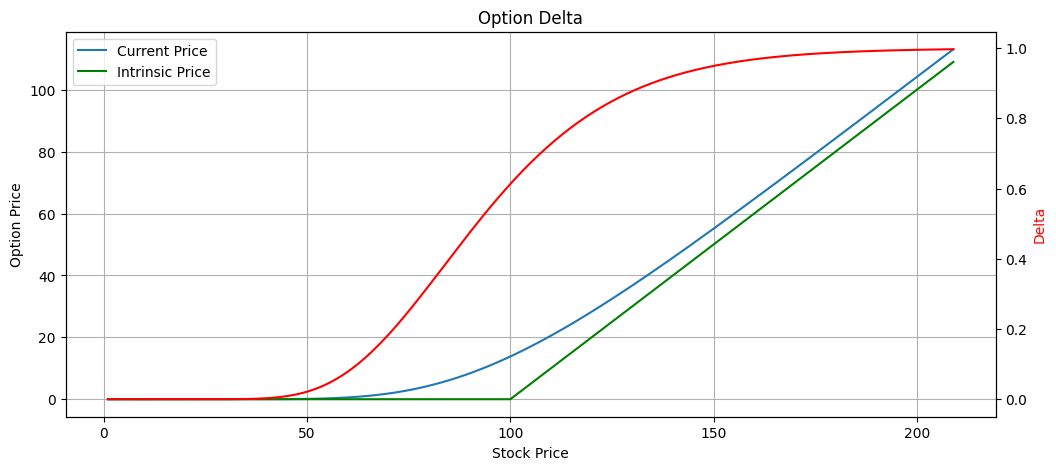

In [622]:
fig, ax1 = plt.subplots(figsize=(12, 5))
plt.grid(True)
plt.title("Option Delta")
plt.xlabel("Stock Price")
ax1.plot(prices.keys(), prices.values(), label="Current Price")
ax1.plot(intrinsic_prices.keys(), intrinsic_prices.values(), label="Intrinsic Price", color='green')
ax1.set_ylabel("Option Price")
ax2 = ax1.twinx()
ax2.plot(delta.keys(), delta.values(), label="Delta", color='red')
ax2.set_ylabel("Delta", color='red')
ax1.legend()

# Gamma
#### Sensitivity of delta to changes in stock price
<hr/>

$$ \Gamma = \frac{\partial \Delta}{\partial S} $$

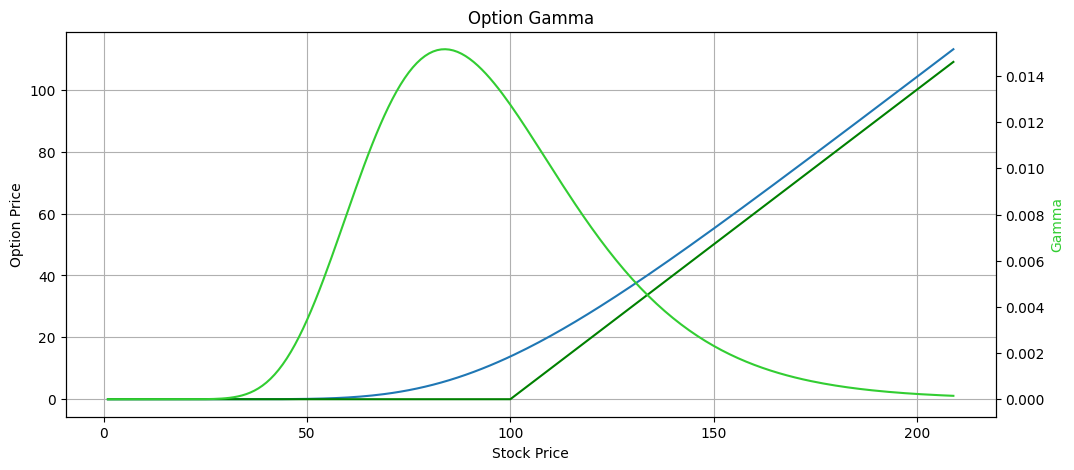

In [623]:
fig, ax1 = plt.subplots(figsize=(12, 5))
plt.title("Option Gamma")
plt.grid(True)
plt.xlabel("Stock Price")
ax1.set_ylabel("Option Price")
ax1.plot(prices.keys(), prices.values(), label="Current Price")
ax1.plot(intrinsic_prices.keys(), intrinsic_prices.values(), label="Intrinsic Price", color='green')
ax2 = ax1.twinx()
ax2.set_ylabel("Gamma", color='limegreen')
ax2.plot(gamma.keys(), gamma.values(), color='limegreen')

# Charm - Delta Decay
#### Sensitivity of delta to changes in time
<hr/>

$$ Charm =  \frac{\partial \Delta}{\partial t} $$

In [624]:
option = Option("call", 100,100,0.16,0.3,0.0412)
dt = option.years / 252
option_prices = {}
charm = {}
delta_t = {}
while option.years > 0.003:
    option_prices[option.years] = option.price()
    delta_t[option.years] = option.delta()
    charm[option.years] = option.charm() * (1 / 252)
    option.years -= dt

Text(0, 0.5, 'Delta')

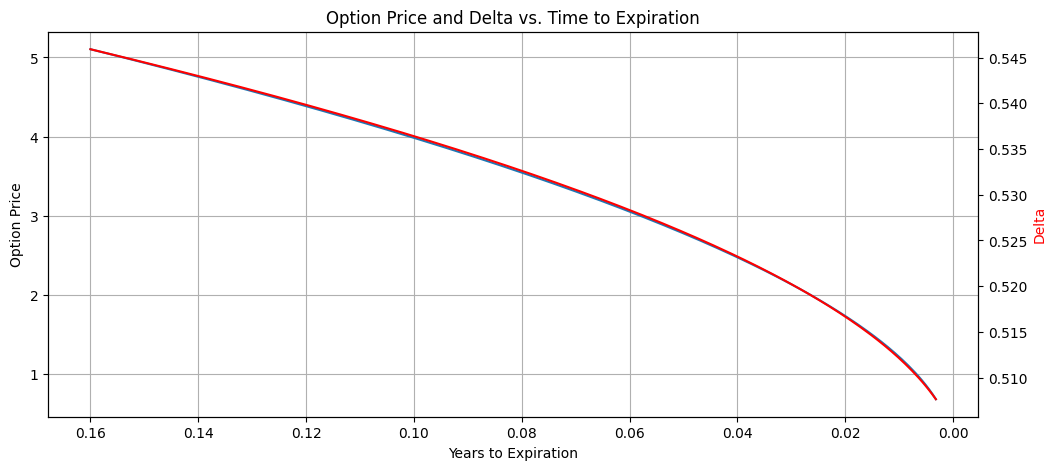

In [625]:
fig, ax1 = plt.subplots(figsize=(12, 5))
plt.title("Option Price and Delta vs. Time to Expiration")
plt.grid(True)
plt.gca().invert_xaxis()
plt.xlabel("Years to Expiration")
ax1.set_ylabel("Option Price")
ax1.plot(option_prices.keys(), option_prices.values(), label='Option Price')
ax2 = ax1.twinx()
ax2.plot(delta_t.keys(), delta_t.values(), label='Delta', color='red')
ax2.set_ylabel("Delta", color='red')

Text(0, 0.5, 'Charm (Daily)')

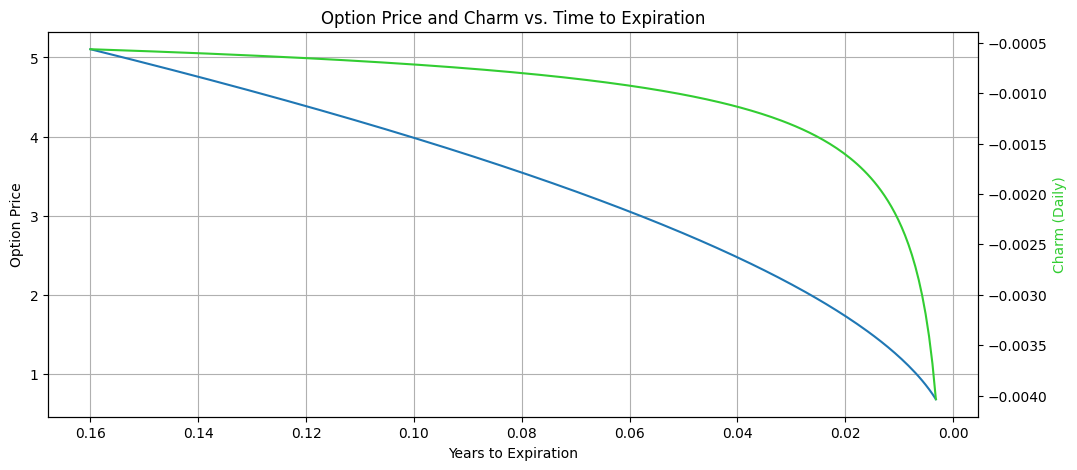

In [626]:
fig, ax1 = plt.subplots(figsize=(12, 5))
plt.title("Option Price and Charm vs. Time to Expiration")
plt.grid(True)
plt.gca().invert_xaxis()
plt.xlabel("Years to Expiration")
ax1.set_ylabel("Option Price")
ax1.plot(option_prices.keys(), option_prices.values(), label='Option Price')
ax2 = ax1.twinx()
ax2.plot(charm.keys(), charm.values(), label='Charm (Daily)', color='limegreen')
ax2.set_ylabel("Charm (Daily)", color='limegreen')

# Vanna
#### Sensitivity of delta to changes in implied volatility
<hr/>

$$ Vanna = \frac{\partial \Delta}{\partial \sigma} $$

In [627]:
option = Option("call", 100,120, 1,0.3,0.0412)
vanna_vals = {}
delta_vals = {}
price_vals = {}
for i in range (1, 100):
    vol = i / 100
    option.implied_vol = vol
    price_vals[i] = option.price()
    vanna_vals[i] = option.vanna() * 0.01
    delta_vals[i] = option.delta()

Text(0, 0.5, 'Delta')

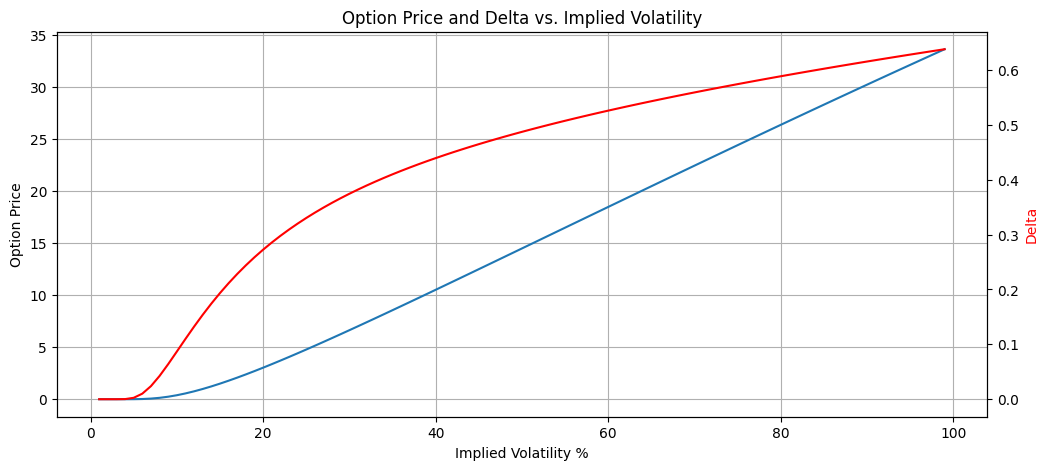

In [628]:
fig, ax1 = plt.subplots(figsize=(12, 5))
plt.grid(True)
plt.title("Option Price and Delta vs. Implied Volatility")
plt.xlabel("Implied Volatility %")
ax1.plot(price_vals.keys(), price_vals.values(), label='Option Prices')
ax1.set_ylabel("Option Price")
ax2 = ax1.twinx()
ax2.plot(delta_vals.keys(), delta_vals.values(), label='Delta', color='red')
ax2.set_ylabel("Delta", color='red')

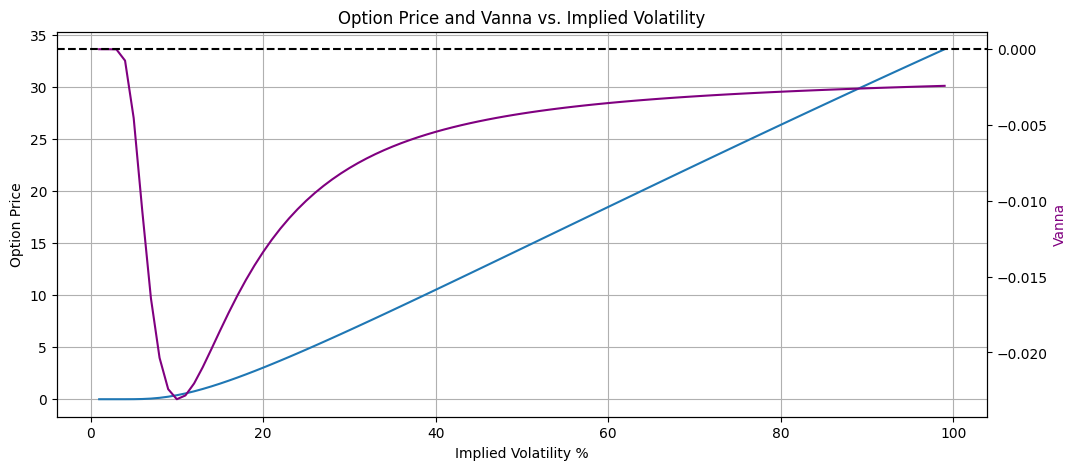

In [630]:
fig, ax1 = plt.subplots(figsize=(12, 5))
plt.grid(True)
plt.title("Option Price and Vanna vs. Implied Volatility")
plt.xlabel("Implied Volatility %")
ax1.plot(price_vals.keys(), price_vals.values(), label='Option Price')
ax1.set_ylabel("Option Price")
ax2 = ax1.twinx()
ax2.plot(vanna_vals.keys(), vanna_vals.values(), label='Vanna', color='purple')
ax2.set_ylabel("Vanna", color='purple')
ax2.axhline(0, color='k', linestyle='--')